In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate


from sklearn.tree import DecisionTreeClassifier 

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier





In [2]:
features_df = pd.read_csv('Data/training_set_features.csv', index_col="respondent_id")
labels_df = pd.read_csv('Data/training_set_labels.csv', index_col="respondent_id")
joined_df = features_df.join(labels_df, how = 'inner')

### A detailed overview and explanation of our data cleaning steps:

The following steps were taken to clean our database.

First we dropped the columns of employment_industry and employment_occupation. Both columns showed a high number of null datapoints with no good way to impute data. Rather than lose 13330 rows of data, we decided to lose these two columns and let the rest of our socio-economic data stand in as proxy.

Next we faced categories with a scattering of data with no real way to impute information. We simply dropped rows with nulls in these columns, slightly (but only slightly) reducing our data set.

Then we created a few special case imputations for some of our data. Most of these columns relate to responses to survery data. Here we imputed default answers as made sense. For instance, if someone fails to answer for whether or not they have a chronic medical condition, we assume that they do not. If a condition was severe enough to be chronic, we feel that a respondent would be aware of that enough to mark yes. These assumptions won't ne right all the time, but we believe that they'll still add to the predictive power of the model. 

The decisions imputations made are as follows:

* Blanks on survey questions were imputed to the 'neutral' or 'don't know' values.

* In behavioral columns we imputed with the majority class. 

* We assumed that if a patient had a doctor's recommendation they would say so.

* And finally was assumed that if a respondent had close contact with a child under 6 months they would know that, and we imputed a no reseponse.

After this data cleaning we are left with a large number of null values in the health insurance column. We felt that this factor was to important to drop, as we had been forced to for employment_industry, for instance. Instead we decided to impute that data via KNN imputation. However, that will have to wait until after we've split the test and training data.

In [3]:
# an all-in-one data cleaning function. Do this BEFORE OHE
# Maybe this should be a class and worked into the pipeline?
def datacleaner(maindataframe):
    #For dropping whole columns 
    def columndrop(dataframe, column_list):
        dataframe.drop(column_list, axis = 1, inplace=True)
    #For dropping rows with na values
    def basicdropna(dataframe, column_list):
        dataframe.dropna(subset=column_list, inplace=True)
    #For special case imputation
    def impute_missing_data(dataframe, column_list, fillvalue):
        for column in column_list:
            dataframe[column].fillna(fillvalue, inplace = True)
    #This creates a number of lists of columns that fall into a few different 
    #categories, that will be processed in different ways. See notes below on how
    #these choices were made.
    drop_columns =  ['employment_industry',  'employment_occupation', 'hhs_geo_region']       
        
    general_dropna = ['health_worker', 'education','income_poverty', 'marital_status', 
                    'rent_or_own', 'employment_status', 'household_adults', 
                    'household_children' ]
        
    survey_col = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
         'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc']

    behavior_col = ['behavioral_antiviral_meds', 'behavioral_face_mask',
                'behavioral_large_gatherings','behavioral_outside_home']

    behavior_col_2 = ['behavioral_avoidance', 
                'behavioral_wash_hands','behavioral_touch_face']

    doc_rec = ['doctor_recc_h1n1','doctor_recc_seasonal']
    
    basicdropna(maindataframe, general_dropna)
    columndrop(maindataframe, drop_columns)
    impute_missing_data(maindataframe, survey_col, 3)
    impute_missing_data(maindataframe, ['h1n1_concern'], 2)
    impute_missing_data(maindataframe, ['h1n1_knowledge'], 0)
    impute_missing_data(maindataframe, behavior_col, 0)
    impute_missing_data(maindataframe, behavior_col_2, 1)
    impute_missing_data(maindataframe, doc_rec, 0)
    impute_missing_data(maindataframe, ['chronic_med_condition'], 0)
    impute_missing_data(maindataframe, ['child_under_6_months'], 0)


In [4]:
datacleaner(joined_df)

In [5]:
X=joined_df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
y=joined_df[['h1n1_vaccine','seasonal_vaccine']]

# Train test split, do this before OHE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# create OHE for objects, do this before imputer

cat_col_list = [i for i in X_train.select_dtypes(include='object').columns]

nb_list_for_ohe = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Fits OHE on a subset of columns, then reintegrates them into the
# Origional dataframe. Do this after initial cleaning, before 
# health insurace imputation.

ohe = OneHotEncoder(drop='first', sparse=False)

def fit_trans_ohe(X_dataframe, columns):
    dums = ohe.fit_transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cols_dropped = X_dataframe.drop(columns, axis = 1)
    dums_df_concated = pd.concat([df_cols_dropped, dums_df], axis=1)
    return dums_df_concated

#We should end up with a fitted ohe instance called 'ohe'

In [7]:
X_train_ohe = fit_trans_ohe(X_train, cat_col_list+nb_list_for_ohe)

In [8]:
    
socio_economic_column_list = ["x0_35 - 44 Years","x0_45 - 54 Years","x0_55 - 64 Years","x0_65+ Years",
                              "x1_< 12 Years","x1_College Graduate","x1_Some College","x2_Hispanic",
                              "x2_Other or Multiple","x2_White","x3_Male", "x4_> $75,000", "x4_Below Poverty",
                              "x5_Not Married", "x6_Rent", "x7_Not in Labor Force","x7_Unemployed",
                              "x8_MSA, Principle City",'x8_Non-MSA', 'health_insurance']

# Fitting an imputer for Health Insurance using socio-economic features, 
# pulling from a dataframe that has already been OneHotEncoded


soc_eco_h_i_imputer_knn = KNNImputer()

def soc_eco_KNN_imputer(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.fit_transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round() 

    return output_df


Here is where we imputed the missing health insurance data into our completed dataframe. We elected to use the socio_economic columns to impute the missing data.

In [9]:
X_train_imputed = soc_eco_KNN_imputer(soc_eco_h_i_imputer_knn, X_train_ohe, socio_economic_column_list)

In [10]:
# The OHE for the test set only, takes X test dataframe and list of columns to encoded:
def trans_ohe(X_dataframe, columns):
    dums = ohe.transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cols_dropped = X_dataframe.drop(columns, axis = 1)
    dums_df_concated = pd.concat([df_cols_dropped, dums_df], axis=1)
    return dums_df_concated

In [11]:
X_test_ohe = trans_ohe(X_test, cat_col_list+nb_list_for_ohe)

In [12]:
# This imputer is trained on the training data, and only transforms the test data.
def imputer_transform_only(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round()
    
    return output_df

In [13]:
X_test_imputed = imputer_transform_only(soc_eco_h_i_imputer_knn, X_test_ohe, socio_economic_column_list)

### We now have a working dataset of: 
    'X_train_imputed' and 'y_train' to fit models to, 'X_test_ohe' to generate predictions, and 'y_test' to validate models with.

### Baseline Model

In [14]:
y_train.h1n1_vaccine.value_counts(normalize=True) # =>Change to DummyClassifier  

0    0.783521
1    0.216479
Name: h1n1_vaccine, dtype: float64

In [15]:
y_train.seasonal_vaccine.value_counts(normalize=True)  # =>Change to DummyClassifier  

0    0.531887
1    0.468113
Name: seasonal_vaccine, dtype: float64

### Decision Tree Classifier

In [16]:

# HlN1 

dt_f = DecisionTreeClassifier(criterion='entropy', splitter='random')

dt_f.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_dt = cross_val_score(dt_f, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc', cv=5).mean()

#Seasonal Flu

dt_sea = DecisionTreeClassifier(criterion='entropy', splitter='random')

dt_sea.fit(X_train_imputed, y_train.seasonal_vaccine)

sea_dt = cross_val_score(dt_sea, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc', cv=5).mean()

print(f'Decision Tree, H1N1, cv ROC_AUC score:{h1n1_dt}')
print(f'Decision Tree, Seasonal, cv ROC_AUC score:{sea_dt}')



Decision Tree, H1N1, cv ROC_AUC score:0.6459870151494881
Decision Tree, Seasonal, cv ROC_AUC score:0.6821051953369494


### KNN

In [17]:
# HlN1 

knn_f_h1 = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
knn_f_h1.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_knn = cross_val_score(knn_f_h1, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc', cv=5).mean()

# Seasonal Flu 

knn_f_s = KNeighborsClassifier(n_neighbors=27, metric='manhattan')
knn_f_s.fit(X_train_imputed, y_train.seasonal_vaccine)

sea_knn = cross_val_score(knn_f_s, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc', cv=5).mean()


print(f'KNN, H1N1, cv ROC_AUC score:{h1n1_knn}')
print(f'KNN, Seasonal, cv ROC_AUC score:{sea_knn}')




KNN, H1N1, cv ROC_AUC score:0.7833193289297442
KNN, Seasonal, cv ROC_AUC score:0.8195432415913972


### Logistic Regression

In [18]:

# H1N1 
# {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000000, 'penalty': 'l1', 'solver': 'saga'}


log_f_h1=LogisticRegression(C=1,penalty="l1", class_weight='balanced', max_iter=1000000,
                              solver='saga')

log_f_h1.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_log = cross_val_score(estimator=log_f_h1, X=X_train_imputed, y=y_train.h1n1_vaccine, 
                cv=5, scoring='roc_auc').mean() 

# Seasonal 
#{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}


log_f_s=LogisticRegression(C=1,penalty="l1", class_weight='balanced', max_iter=10000,
                              solver='saga')
log_f_s.fit(X_train_imputed, y_train.h1n1_vaccine)

sea_log = cross_val_score(estimator=log_f_s, X=X_train_imputed, y=y_train.seasonal_vaccine, 
                cv=5, scoring='roc_auc').mean() 


print(f'Logistic, H1N1, cv ROC_AUC score:{h1n1_log}')
print(f'Logistic, Seasonal, cv ROC_AUC score:{sea_log}')


Logistic, H1N1, cv ROC_AUC score:0.8395998340067689
Logistic, Seasonal, cv ROC_AUC score:0.8564302239348631


### GradientBoostingClassifier

In [19]:
# H1N1 

gbc_f_h1 = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_h1.fit(X_train_imputed, y_train['h1n1_vaccine'])

h1n1_gbc = cross_val_score(gbc_f_h1, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc')



In [20]:
# Seasonal Flu

gbc_f_s = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_s.fit(X_train_imputed, y_train['seasonal_vaccine'])

sea_gbc = cross_val_score(gbc_f_s, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc')

print(f'GradientBoostingClassifier, H1N1, cv ROC_AUC score:    {h1n1_gbc}')
print(f'GradientBoostingClassifier, Seasonal, cv ROC_AUC score:{sea_gbc}')


GradientBoostingClassifier, H1N1, cv ROC_AUC score:    [0.84035455 0.83734749 0.85665468 0.82388416 0.8464676 ]
GradientBoostingClassifier, Seasonal, cv ROC_AUC score:[0.85969924 0.855889   0.85191652 0.86600335 0.85620959]


### ROC curve

#### H1N1

In [21]:
# Get predicted probability 

# DT
y_pred_h1_dt = dt_f.predict_proba(X_test_imputed)[:, 1] #=> Error 

# KNN

y_pred_h1_knn = knn_f_h1.predict_proba(X_test_imputed)[:, 1] 

# Log
y_pred_h1_log = log_f_h1.predict_proba(X_test_imputed)[:, 1]

# GBC 

y_pred_h1_gbc = gbc_f_h1.predict_proba(X_test_imputed)[:, 1]


In [22]:
# Get the FPR and TPR data

# DT
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.h1n1_vaccine, y_pred_h1_dt)

# KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test.h1n1_vaccine, y_pred_h1_knn)

# Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_test.h1n1_vaccine, y_pred_h1_log)

# GBC 
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test.h1n1_vaccine, y_pred_h1_gbc)



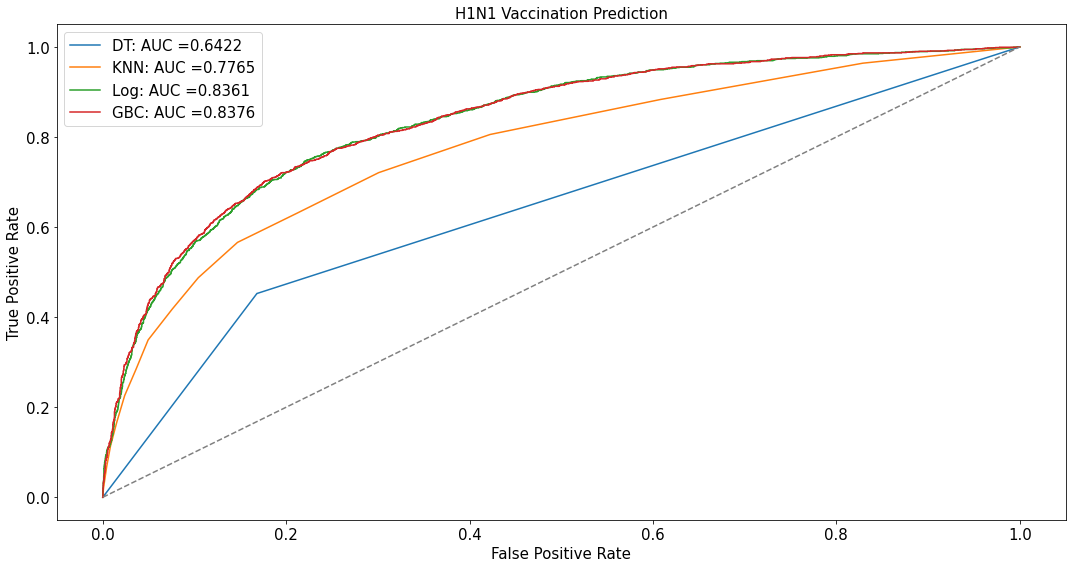

In [23]:

# Plot the FPR and TPR data

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(fpr_dt, tpr_dt, alpha =1, 
        label=f'DT: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_dt),4)}')

ax.plot(fpr_knn, tpr_knn, alpha =1, 
        label=f'KNN: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_knn),4)}')


ax.plot(fpr_log, tpr_log, alpha =1, 
        label=f'Log: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_log),4)}')

ax.plot(fpr_gbc, tpr_gbc, alpha=1,
       label=f'GBC: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('H1N1 Vaccination Prediction', fontsize=15)
    
ax.legend(fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

#### Seasonal Flu

In [24]:
# Get predicted probability 

# DT
y_pred_s_dt = dt_sea.predict_proba(X_test_imputed)[:, 1]

# KNN

y_pred_s_knn = knn_f_s.predict_proba(X_test_imputed)[:, 1]

# Log
y_pred_s_log = log_f_s.predict_proba(X_test_imputed)[:, 1]

# GBC 

y_pred_s_gbc = gbc_f_s.predict_proba(X_test_imputed)[:, 1]


In [25]:
# Get the FPR and TPR data

# DT
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.seasonal_vaccine, y_pred_s_dt)

# KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test.seasonal_vaccine, y_pred_s_knn)

# Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_test.seasonal_vaccine, y_pred_s_log)

# GBC 
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test.seasonal_vaccine, y_pred_s_gbc)



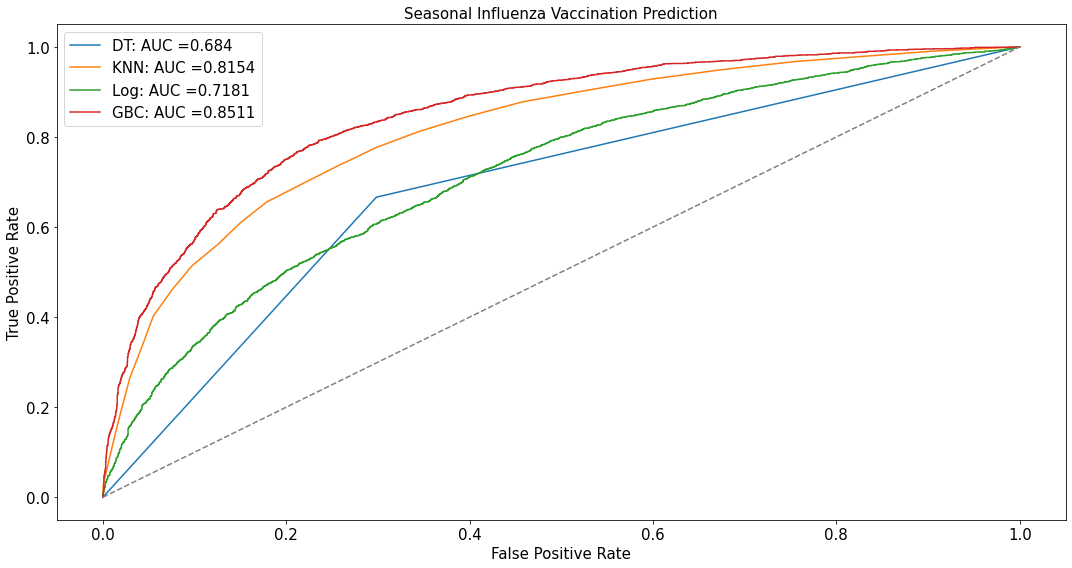

In [26]:

# Plot the FPR and TPR data

fig, ax = plt.subplots(figsize=(15, 8))


ax.plot(fpr_dt, tpr_dt, alpha =1, 
        label=f'DT: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_dt),4)}')

ax.plot(fpr_knn, tpr_knn, alpha =1, 
        label=f'KNN: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_knn),4)}')

ax.plot(fpr_log, tpr_log, alpha =1, 
        label=f'Log: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_log),4)}')

ax.plot(fpr_gbc, tpr_gbc, alpha=1,
       label=f'GBC: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('Seasonal Influenza Vaccination Prediction', fontsize=15)
    
ax.legend(fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

### Analysis

In [27]:
# Use GBD model for analysis 

In [28]:
# Assign a new data frame df 

df = X_test.copy()

# Merge y_test 

df = pd.concat([df, y_test], axis=1) 

# Add predicted probabilities 

# H1N1 
df['h1n1_prob_0'] = gbc_f_h1.predict_proba(X_test_imputed)[:,0] 
df['h1n1_prob_1'] = gbc_f_h1.predict_proba(X_test_imputed)[:,1]

# Seasonal Flu
df['seasonal_prob_0'] = gbc_f_s.predict_proba(X_test_imputed)[:,0] 
df['seasonal_prob_1'] = gbc_f_s.predict_proba(X_test_imputed)[:,1]


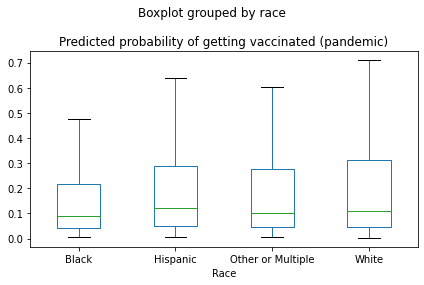

In [29]:

df.boxplot(column='h1n1_prob_1', by ='race', showfliers = False)

plt.title('Predicted probability of getting vaccinated (pandemic)')


plt.xlabel('Race')
plt.grid(False)
plt.tight_layout();

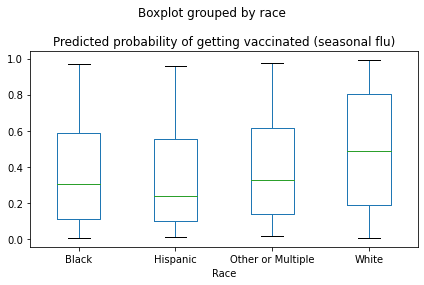

In [30]:
df.boxplot(column='seasonal_prob_1', by ='race', showfliers = False)

plt.title('Predicted probability of getting vaccinated (seasonal flu)')


plt.xlabel('Race')
plt.grid(False)
plt.tight_layout();

In [31]:
zipzip = zip(gbc_f_s.feature_importances_,X_train_imputed.columns)
season_vax_fi = pd.DataFrame(data = zipzip, columns = ['importance','feature'])
zipzipzip = zip(gbc_f_h1.feature_importances_,X_train_imputed.columns)
h1n1_vax_fi = pd.DataFrame(data = zipzipzip, columns = ['importance','feature'])
h1n1_vax_fi.sort_values('importance', ascending = False, inplace = True)
h1n1_vax_fi_topten = h1n1_vax_fi.head(10)

In [41]:
h1n1_vax_fi_topten

,importance,feature
7,0.331434,doctor_recc_h1n1
25,0.105272,x12_4.0
22,0.097777,x11_5.0
26,0.073714,x12_5.0
11,0.052691,health_worker
37,0.029359,x15_4.0
8,0.025522,doctor_recc_seasonal
20,0.024069,x11_3.0
38,0.019857,x15_5.0
19,0.016928,x11_2.0


In [101]:
feat_renamed = ['Doc. Recomends H1N1 Vax', 'Moderate Concern: H1N1', 'Confident: H1N1 Vax Efficacy', 
                'Great Concern: H1N1', 'Health Care Worker', 'Moderate Concern: Flu', 'Doc. Recomends Flu Vax',
               'No Opinion: H1N1 Vax Efficacy', 'Great Concern: Flu', 'Moderate Concern: H1N1 Vax Efficacy']

h1n1_vax_fi_topten['Top Features'] = feat_renamed



<ipython-input-101-90f33eefb042>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h1n1_vax_fi_topten['Top Features'] = feat_renamed


In [102]:
h1n1_vax_fi_topten

,importance,feature,Top Features
7,0.331434,doctor_recc_h1n1,Doc. Recomends H1N1 Vax
25,0.105272,x12_4.0,Moderate Concern: H1N1
22,0.097777,x11_5.0,Confident: H1N1 Vax Efficacy
26,0.073714,x12_5.0,Great Concern: H1N1
11,0.052691,health_worker,Health Care Worker
37,0.029359,x15_4.0,Moderate Concern: Flu
8,0.025522,doctor_recc_seasonal,Doc. Recomends Flu Vax
20,0.024069,x11_3.0,No Opinion: H1N1 Vax Efficacy
38,0.019857,x15_5.0,Great Concern: Flu
19,0.016928,x11_2.0,Moderate Concern: H1N1 Vax Efficacy


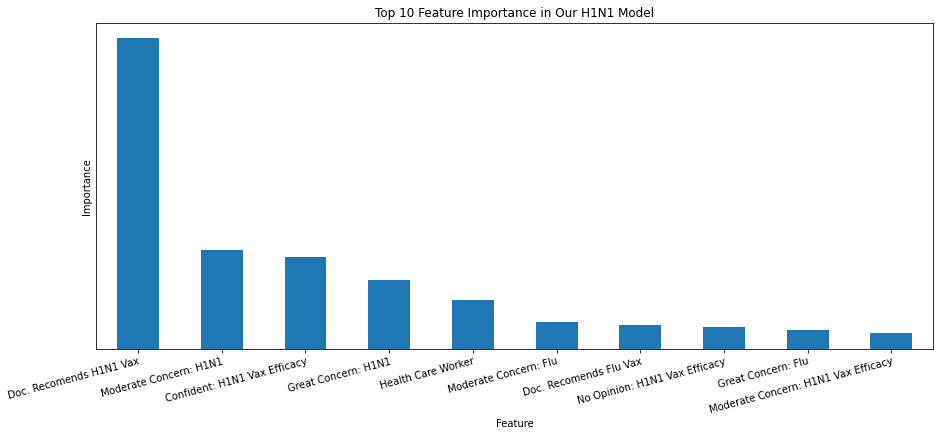

In [115]:
h1n1_vax_fi_topten.plot.bar(x= 'Top Features', y = 'importance', figsize = (15,6), title = 'Top 10 Feature Importance in Our H1N1 Model',
                    ylabel = 'Importance', xlabel = 'Feature', legend = None)
plt.xticks(rotation=15, rotation_mode='anchor', ha='right')
plt.yticks([]);


In [117]:
season_vax_fi.sort_values('importance', ascending = False, inplace = True)
season_vax_fi_topten = season_vax_fi.head(10)
s_feat_renamed = ['Doc. Recomends Flu Vax', 'Great Confidence: Flu Vax Efficacy', 'Moderate Concern: Flu',
                  '65+ Years Old', 'Great Concern: Flu',  'Doc. Recomends H1N1 Vax', 
                  'Moderate Concern: Flu Vax Efficacy', 'Health Care Worker', 'Moderate Concern: H1N1',
                  'Has Health Insurance'
                  ]
season_vax_fi_topten['Top Features'] = s_feat_renamed
season_vax_fi_topten

<ipython-input-117-ee471a168d5a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_vax_fi_topten['Top Features'] = s_feat_renamed


,importance,feature,Top Features
8,0.153504,doctor_recc_seasonal,Doc. Recomends Flu Vax
34,0.152898,x14_5.0,Great Confidence: Flu Vax Efficacy
37,0.108192,x15_4.0,Moderate Concern: Flu
46,0.089857,x0_65+ Years,65+ Years Old
38,0.067101,x15_5.0,Great Concern: Flu
7,0.040195,doctor_recc_h1n1,Doc. Recomends H1N1 Vax
31,0.039760,x14_2.0,Moderate Concern: Flu Vax Efficacy
11,0.030990,health_worker,Health Care Worker
25,0.025458,x12_4.0,Moderate Concern: H1N1
62,0.020960,health_insurance,Has Health Insurance


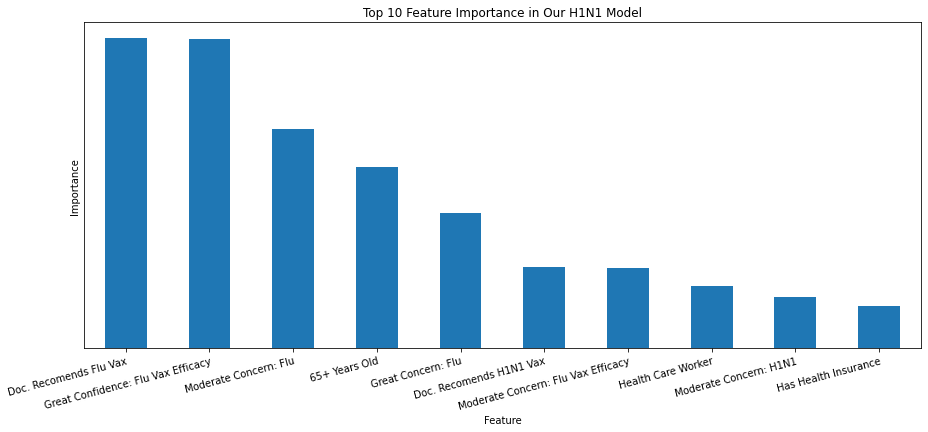

In [118]:
season_vax_fi_topten.plot.bar(x= 'Top Features', y = 'importance', figsize = (15,6), title = 'Top 10 Feature Importance in Our H1N1 Model',
                    ylabel = 'Importance', xlabel = 'Feature', legend = None)
plt.xticks(rotation=15, rotation_mode='anchor', ha='right')
plt.yticks([]);


''

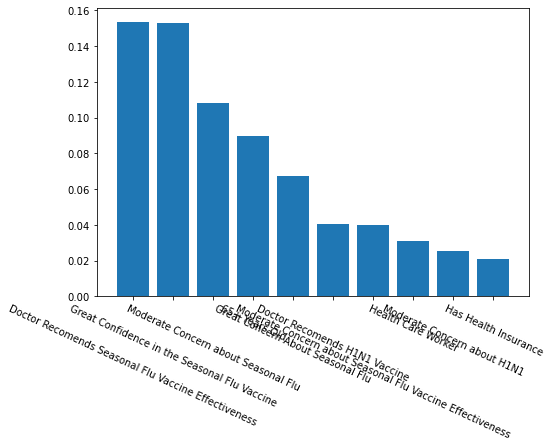

In [91]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, ])
ax1.bar(season_vax_fi_topten['Top Features'], season_vax_fi_topten['importance'])
plt.xticks(rotation=-25)
;

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Doctor Recomends Seasonal Flu Vaccine Effectiveness'),
  Text(1, 0, 'Great Confidence in the Seasonal Flu Vaccine'),
  Text(2, 0, 'Moderate Concern about Seasonal Flu'),
  Text(3, 0, '65+ Years Old'),
  Text(4, 0, 'Great Concern About Seasonal Flu'),
  Text(5, 0, 'Doctor Recomends H1N1 Vaccine'),
  Text(6, 0, 'Moderate Concern about Seasonal Flu Vaccine Effectiveness'),
  Text(7, 0, 'Health Care Worker'),
  Text(8, 0, 'Moderate Concern about H1N1'),
  Text(9, 0, 'Has Health Insurance')])

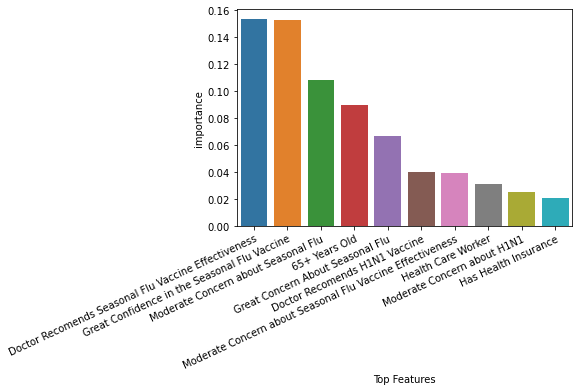

In [100]:
sns.barplot(x = season_vax_fi_topten['Top Features'], y = season_vax_fi_topten['importance'])
plt.xticks(rotation=25, rotation_mode='anchor', ha='right')
 

In [119]:
gbc_f_s.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2',
                      random_state=RandomState(MT19937) at 0x215AA2B0840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2',
                      random_state=RandomState(MT19937) at 0x215AA2B0840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2',
                      random_state=RandomState(MT19937) at 0x215AA2B0840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2',
                      random_state=RandomState(MT19937) at 0x215AA2B0840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2',
                      random_state=RandomState(MT19937) at 0x215AA2B0840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_